<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 5**
## Ensemble

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

print("Done")

Done


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
#PAT = 4

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models")
MODEL_PRETRAINED_PATH = os.path.join(MODEL_PATH, "Pretrained")
MODEL_SCRATCH_PATH = os.path.join(MODEL_PATH, "Scratch")
MODEL_ENSEMBLE_PATH = os.path.join(MODEL_PATH, "Ensemble")
PLOTS_PATH = os.path.join(base_path, "plots/Ensemble")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()

  return i, j

# Unify masses and calcifications 
def labels_mapping_masscalc(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  #labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
      idx += 1
    # Calcifications
    if label == 3 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

# Unify mal and ben 
def labels_mapping_benmal(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  #labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
      idx += 1
    # Malign
    if label == 2 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

print("Done")

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss))
  #print("Precision:", "%0.2f" % (test_precision*100), "%")
  #print("Recall:", "%0.2f" % (test_recall*100), "%")
  #print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")

print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tra_loss_0 = history_0.history['loss']
  tra_acc_0 = history_0.history['acc']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']

  # Total number of epochs training
  epochs_0 = range(1, len(tra_acc_0)+1)
  end_epoch_0 = len(tra_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  #acc = history.history['acc']
  #val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+1,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


In [ ]:
#Early stop conditon 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PAT)

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
#class GarbageCollectorCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#      gc.collect()

#print("Done")

In [ ]:
def earlyStop(patience):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
  return callback
print("Done")

Done


# Data operations

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


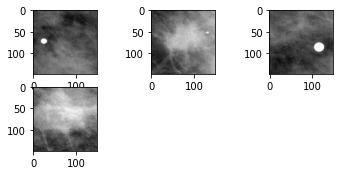

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

# Ensemble Mass Calc


##Data

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping_masscalc(train_labels)
test_labels = labels_mapping_masscalc(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (1338, 150, 150, 1)
Test shape:  (168, 150, 150, 3)


In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (1338, 150, 150, 1, 1)
Test shape:  (168, 150, 150, 3, 1)


In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

Masses samples:  1338


IndexError: ignored

In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./65535)

##Scratch

In [ ]:
test_gen= test_datagen.flow(test_images,
                            test_labels,
                            batch_size=BATCH_SIZE+2,
                            shuffle=False)

In [ ]:
model1 = load_model(os.path.join(MODEL_SCRATCH_PATH,'calcmasses_model4.h5'))
model2 = load_model(os.path.join(MODEL_SCRATCH_PATH,'calcmasses_model1_d2.h5'))
model3 = load_model(os.path.join(MODEL_SCRATCH_PATH,'calcmasses_model6.h5'))
model4 = load_model(os.path.join(MODEL_SCRATCH_PATH,'calcmasses_model91.h5'))

In [ ]:
preds_1=model1.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_2=model2.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_3=model3.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_4=model4.predict(test_gen, steps=len(test_images) // BATCH_SIZE)

final_preds = 0.25 * (preds_1 + preds_2 + preds_3 + preds_4)

(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       179
         1.0       0.90      0.83      0.86       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336



Text(0.5, 0.07448596317420098, 'Predicted label')

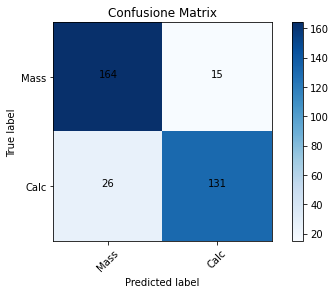

In [ ]:
classes = ["Mass", "Calc"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

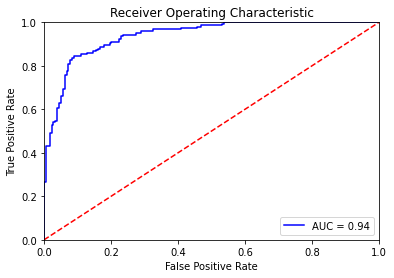

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
preds_scratch = final_preds

##Pretrained

In [ ]:
train_dataset_split = np.repeat(train_dataset_split, 3, axis = 3)
valid_dataset_split = np.repeat(valid_dataset_split, 3, axis = 3)
test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_dataset_split.shape)
print(test_images.shape)


(2140, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
test_gen= test_datagen.flow(test_images,
                            test_labels,
                            batch_size=BATCH_SIZE+2,
                            shuffle=False)

In [ ]:
model5 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model63.h5'))
model6 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model7.h5'))
model7 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model8.h5'))
model8 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model1.h5'))

In [ ]:
preds_5=model5.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_6=model6.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_7=model7.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_8=model8.predict(test_gen, steps=len(test_images) // BATCH_SIZE)

final_preds = 0.25 * (preds_5 + preds_6 + preds_7 + preds_8)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       179
         1.0       0.84      0.85      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



Text(0.5, 0.07448596317420098, 'Predicted label')

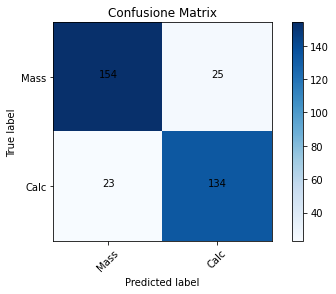

In [ ]:
classes = ["Mass", "Calc"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

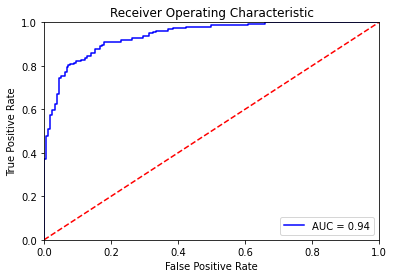

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
preds_pretrained = final_preds

##Average

In [ ]:
#final_preds = 0.5 * (preds_scratch + preds_pretrained)
final_preds = 0.125 * (preds_1 + preds_2 + preds_3 + preds_4 + preds_5 + preds_6 + preds_7 + preds_8)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87       179
         1.0       0.87      0.83      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



Text(0.5, 0.07448596317420098, 'Predicted label')

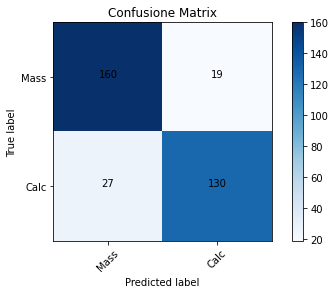

In [ ]:
classes = ["Mass", "Calc"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

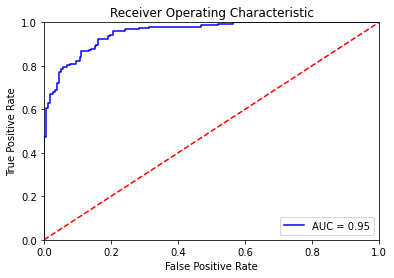

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Pretrained alternative methods

In [ ]:
model1 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model63.h5'))
model2 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model7.h5'))
model3 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model8.h5'))
model4 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'calcmasses_inceptionv3_model1.h5'))

In [ ]:
models = [model1, model2, model3, model4]
model_input = tf.keras.Input(shape=(150, 150, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       179
         1.0       0.84      0.85      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



Text(0.5, -25.558134854838144, 'Predicted label')

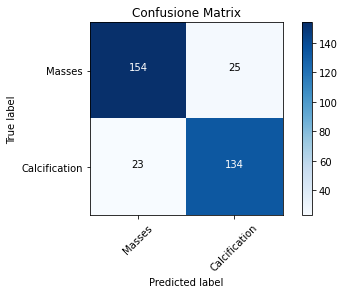

In [ ]:
classes = ["Masses", "Calcification"]
Y_pred = ensemble_model.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

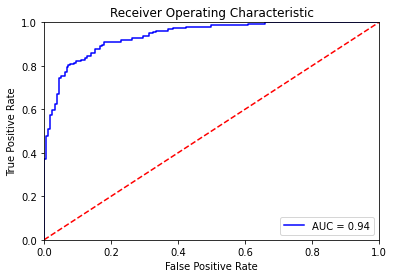

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Training Model

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest'
   )

In [ ]:
model = keras.models.Sequential()
model.add(ensemble_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
ensemble_model.trainable=False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 53s 497ms/step - loss: 0.6990 - acc: 0.3861 - val_loss: 0.6826 - val_acc: 0.5176
Epoch 2/100
66/66 [==============================] - 25s 385ms/step - loss: 0.6664 - acc: 0.5522 - val_loss: 0.6554 - val_acc: 0.5176
Epoch 3/100
66/66 [==============================] - 26s 386ms/step - loss: 0.6397 - acc: 0.5531 - val_loss: 0.6330 - val_acc: 0.5176
Epoch 4/100
66/66 [==============================] - 26s 387ms/step - loss: 0.6199 - acc: 0.5522 - val_loss: 0.6135 - val_acc: 0.5176
Epoch 5/100
66/66 [==============================] - 26s 385ms/step - loss: 0.6010 - acc: 0.5508 - val_loss: 0.5953 - val_acc: 0.5273
Epoch 6/100
66/66 [==============================] - 26s 386ms/step - loss: 0.5816 - acc: 0.6276 - val_loss: 0.5792 - val_acc: 0.6504
Epoch 7/100
66/66 [==============================] - 26s 385ms/step - loss: 0.5705 - acc: 0.6589 - val_loss: 0.5651 - val_acc: 0.6895
Epoch 8/100
66/66 [==============================] - 26s 386ms

In [ ]:
model.save(os.path.join(MODEL_ENSEMBLE_PATH, 'calcmasses_ensemble_model2.h5'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


ValueError: ignored

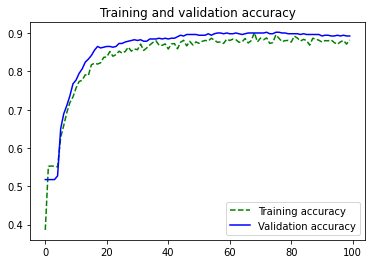

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'calcmasses_ensemble_model1_acc.png'))
plt_a.show()

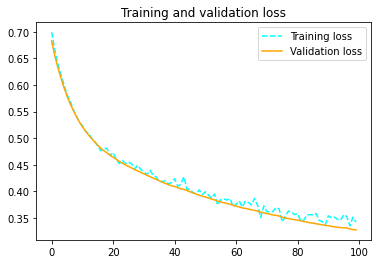

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'calcmasses_ensemble_model1_loss.png'))

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 73
Valid accuracy [end]: 0.8926
Valid accuracy [opt]: 0.9023
Valid loss [end]: 0.3278
Valid loss [opt]: 0.3558


In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("---------------------------------\n")

10/10 [==============================] - 4s 350ms/step - loss: 0.3946 - acc: 0.8562

---------------------------------
Accuracy: 85.62 %
Loss: 0.39
---------------------------------



In [ ]:
model_best = model

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87       179
         1.0       0.84      0.85      0.85       157

    accuracy                           0.86       336
   macro avg       0.86      0.86      0.86       336
weighted avg       0.86      0.86      0.86       336



Text(0.5, -6.819805153394636, 'Predicted label')

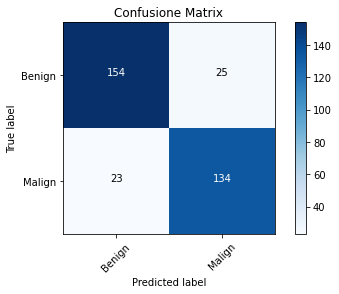

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

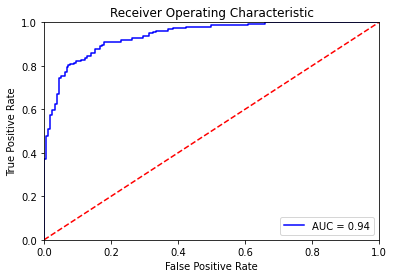

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Ensemble Ben Mal


##Data

In [ ]:
# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Mapping labels with standard index
train_labels = labels_mapping_benmal(train_labels)
test_labels = labels_mapping_benmal(test_labels)

# Suffle index (Previous dataset is ordered by index)
train_images, train_labels = shuffle_dataset(train_images, train_labels)
test_images, test_labels = shuffle_dataset(test_images, test_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


In [ ]:
# Prepare the data with the expected format
train_images = train_images.reshape(train_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 1)
Test shape:  (336, 150, 150, 1)


In [ ]:
#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Masses samples: ", counts[0])
print("Calcifications samples: ", counts[1])

Masses samples:  1568
Calcifications samples:  1108


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_images))
train_dataset_split = train_images[:split_index]
valid_dataset_split = train_images[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]

print(train_dataset_split.shape)
print(valid_dataset_split.shape)

(2140, 150, 150, 1)
(536, 150, 150, 1)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./65535)

##Scratch

In [ ]:
test_gen= test_datagen.flow(test_images,
                            test_labels,
                            batch_size=BATCH_SIZE+2,
                            shuffle=False)

In [ ]:
model1 = load_model(os.path.join(MODEL_SCRATCH_PATH,'benmal_modelbest.h5'))
model2 = load_model(os.path.join(MODEL_SCRATCH_PATH,'benmal_model8.h5'))
model3 = load_model(os.path.join(MODEL_SCRATCH_PATH,'benmal_model3.h5'))
model4 = load_model(os.path.join(MODEL_SCRATCH_PATH,'benmal_model14.h5'))

In [ ]:
preds_1=model1.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_2=model2.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_3=model3.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_4=model4.predict(test_gen, steps=len(test_images) // BATCH_SIZE)

final_preds = 0.25 * (preds_1 + preds_2 + preds_3 + preds_4)

(336,)
(336, 150, 150, 1)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.66      0.71       219
         1.0       0.50      0.65      0.57       117

    accuracy                           0.65       336
   macro avg       0.64      0.65      0.64       336
weighted avg       0.68      0.65      0.66       336



Text(0.5, -6.819805153394636, 'Predicted label')

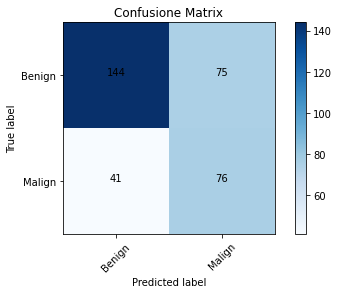

In [ ]:
classes = ["Benign", "Malign"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

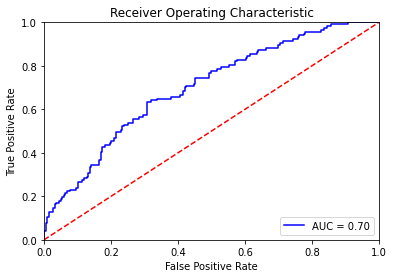

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
preds_scratch = final_preds

##Pretrained

In [ ]:
train_dataset_split = np.repeat(train_dataset_split, 3, axis = 3)
valid_dataset_split = np.repeat(valid_dataset_split, 3, axis = 3)
test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_dataset_split.shape)
print(test_images.shape)


(2140, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
test_gen= test_datagen.flow(test_images,
                            test_labels,
                            batch_size=BATCH_SIZE+2,
                            shuffle=False)

In [ ]:
model5 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model2.h5'))
model6 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model9.h5'))
model7 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model611.h5'))
model8 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model5.h5'))

In [ ]:
preds_5=model5.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_6=model6.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_7=model7.predict(test_gen, steps=len(test_images) // BATCH_SIZE)
preds_8=model8.predict(test_gen, steps=len(test_images) // BATCH_SIZE)

final_preds = 0.25 * (preds_5 + preds_6 + preds_7 + preds_8)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       219
         1.0       0.57      0.69      0.63       117

    accuracy                           0.71       336
   macro avg       0.69      0.71      0.70       336
weighted avg       0.73      0.71      0.72       336



Text(0.5, -6.819805153394636, 'Predicted label')

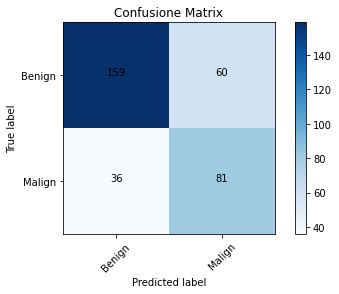

In [ ]:
classes = ["Benign", "Malign"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

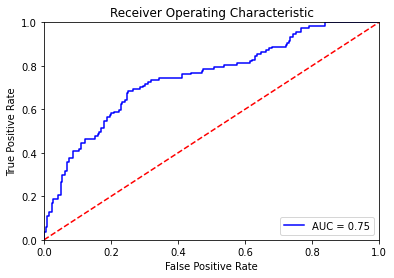

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
preds_pretrained = final_preds

##Average

In [ ]:
#final_preds = 0.5 * (preds_scratch + preds_pretrained)
final_preds = 0.125 * (preds_1 + preds_2 + preds_3 + preds_4 + preds_5 + preds_6 + preds_7 + preds_8)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.80      0.68      0.74       219
         1.0       0.53      0.68      0.60       117

    accuracy                           0.68       336
   macro avg       0.67      0.68      0.67       336
weighted avg       0.71      0.68      0.69       336



Text(0.5, -6.819805153394636, 'Predicted label')

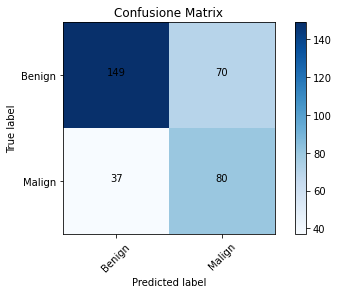

In [ ]:
classes = ["Benign", "Malign"]

y_pred = np.where(final_preds < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(final_preds.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, final_preds)

roc_auc = roc_auc_score(test_labels, final_preds)

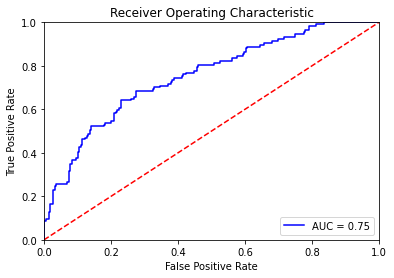

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Pretrained alternative methods

In [ ]:
model1 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model2.h5'))
model2 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model9.h5'))
model3 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model611.h5'))
model4 = load_model(os.path.join(MODEL_PRETRAINED_PATH,'benmal_inceptionv3_model5.h5'))

In [ ]:
model1._name = "model1"
model2._name = "model2"
model3._name = "model3"
model4._name = "model4"

In [ ]:
models = [model1, model2, model3, model4]
model_input = tf.keras.Input(shape=(150, 150, 3))


model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77       219
         1.0       0.57      0.69      0.63       117

    accuracy                           0.71       336
   macro avg       0.69      0.71      0.70       336
weighted avg       0.73      0.71      0.72       336



Text(0.5, -6.819805153394636, 'Predicted label')

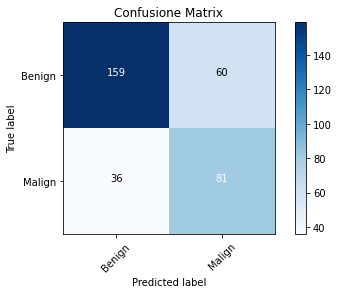

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = ensemble_model.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

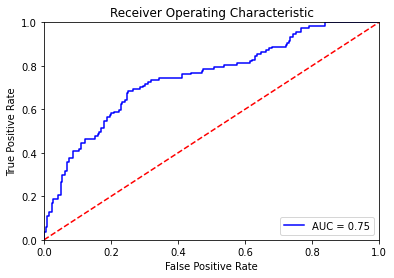

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Training Model Pretrained

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
train_datagen = ImageDataGenerator(
    #preprocessing_function=preprocess_input,
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest'
   )

In [ ]:
model = keras.models.Sequential()
model.add(ensemble_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
ensemble_model.trainable=False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['acc'])

In [ ]:
history = model.fit(train_datagen.flow(train_dataset_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_dataset_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    #callbacks=[callback],
                    validation_data=valid_datagen.flow(valid_dataset_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE)

Epoch 1/100
66/66 [==============================] - 55s 463ms/step - loss: 0.6593 - acc: 0.6831 - val_loss: 0.6202 - val_acc: 0.7363
Epoch 2/100
66/66 [==============================] - 18s 274ms/step - loss: 0.6071 - acc: 0.7073 - val_loss: 0.5596 - val_acc: 0.7754
Epoch 3/100
66/66 [==============================] - 18s 279ms/step - loss: 0.5721 - acc: 0.7163 - val_loss: 0.5209 - val_acc: 0.7617
Epoch 4/100
66/66 [==============================] - 18s 270ms/step - loss: 0.5504 - acc: 0.7177 - val_loss: 0.5051 - val_acc: 0.7773
Epoch 5/100
66/66 [==============================] - 18s 269ms/step - loss: 0.5372 - acc: 0.7158 - val_loss: 0.4912 - val_acc: 0.7598
Epoch 6/100
66/66 [==============================] - 18s 271ms/step - loss: 0.5364 - acc: 0.7139 - val_loss: 0.5041 - val_acc: 0.7539
Epoch 7/100
66/66 [==============================] - 18s 271ms/step - loss: 0.5352 - acc: 0.7173 - val_loss: 0.4882 - val_acc: 0.7656
Epoch 8/100
66/66 [==============================] - 18s 275ms

In [ ]:
model.save(os.path.join(MODEL_ENSEMBLE_PATH, 'benmal_ensemble_model1.h5'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


ValueError: ignored

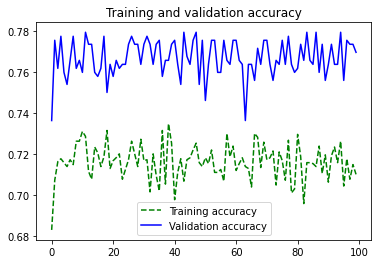

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_ensemble_model1_acc.png'))
plt_a.show()

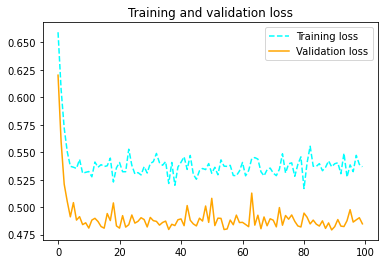

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_l = plot_loss(history)
plt_l.show()
plt_l.savefig(os.path.join(PLOTS_PATH, 'benmal_ensemble_model1_loss.png'))

In [ ]:
print_opt_results(history)

Epoch [end]: 100
Epoch [opt]: 12
Valid accuracy [end]: 0.7695
Valid accuracy [opt]: 0.7793
Valid loss [end]: 0.4848
Valid loss [opt]: 0.4882


In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("---------------------------------\n")

10/10 [==============================] - 2s 149ms/step - loss: 0.5593 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
Loss: 0.56
---------------------------------



In [ ]:
model_best = model

(336,)
(336, 150, 150, 3)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78       219
         1.0       0.58      0.59      0.59       117

    accuracy                           0.71       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.71      0.71       336



Text(0.5, -6.819805153394636, 'Predicted label')

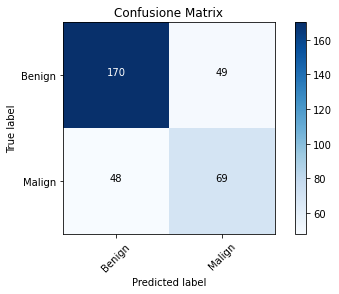

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE+4,
                                            shuffle=False),
                          steps=len(test_images) // BATCH_SIZE)

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

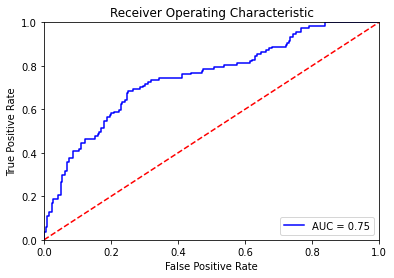

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()